### Data downloaded from https://www.kaggle.com/kingburrito666/better-donald-trump-tweets/data

In [11]:
import numpy as np
from collections import Counter

In [14]:
history_length = 3

def process_input(filename):
    text = open(filename).read()
    sequences = [text[i:i+history_length] for i in range(int(len(text)/history_length))]
    stats = Counter(sequences)
    tokens = []
    counts = []
    for i in stats.most_common():
        tokens.append(i[0])
        counts.append(i[1])
    return stats

def next_char(cur, stats):
    seed = cur[1:]
    candidates = []
    candidatec = []
    for k in stats.keys():
        if seed == k[:-1]:
            candidates.append(k)
            candidatec.append(stats[k])
    candidatep = [x/sum(candidatec) for x in candidatec]
    return candidates[np.random.choice(len(candidates), p=candidatep)]

def sample(length, running_state, stats):
    output = ''
    for i in range(length):
        output += running_state[0]
        running_state = next_char(running_state, stats)
    return output

In [15]:
tweets_stats = process_input('tweets.txt')
sample(50, 'oba', tweets_stats)

'obamil sh  dibizonlyised sed new govemit co zvknow'

In [22]:
history_length = 4

tweets_stats = process_input('tweets.txt')
sample(50, 'obam', tweets_stats)

'obamazing scrimes  afters any of the   ver  ters b'

In [23]:
hamlet_stats = process_input('hamlet.txt')
sample(50, 'and ', hamlet_stats)

'and to say we end the mind that fles, and that fle'


* Above method just uses the history upto a certain number of characters to match the characters. But, there is no context of language generation, eventhough we increase the history length and also it is more memorization than text generation. 
> RNN's shine better in such cases.

## RNN using PyTorch

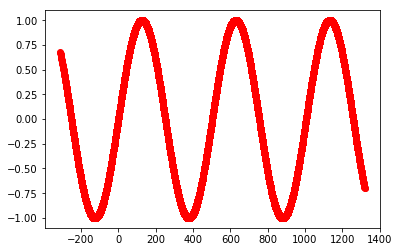

In [44]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt

np.random.seed(0)
torch.manual_seed(0)

T = 80 # range from which ints are sampled
L = 1000 # Length of the sequence
N = 100 # Number of examples

future = 1000 # Length of the sequence to predict

# Generating time series data
x = np.empty((N, L), 'int64')
x[:] = np.array(range(L)) + np.random.randint(-4*T, 4*T, N).reshape(N, 1)
data = np.sin(x/1.0/T).astype('float64')

# Visulizing the input data
plt.plot(x, data, 'ro')
plt.show()

In [53]:
class Sequence(nn.Module):
    def __init__(self):
        super(Sequence, self).__init__()
        self.lstm1 = nn.LSTMCell(1, 32)
        self.lstm2 = nn.LSTMCell(32, 32)
        self.linear = nn.Linear(32, 1)
    def forward(self, input, future=0):
        outputs = []
        h_t = Variable(torch.zeros(input.size(0), 32).double(), requires_grad=False)
        c_t = Variable(torch.zeros(input.size(0), 32).double(), requires_grad=False)
        h_t2 = Variable(torch.zeros(input.size(0), 32).double(), requires_grad=False)
        c_t2 = Variable(torch.zeros(input.size(0), 32).double(), requires_grad=False)
        
        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs += [output]
        for i in range(future):# if we should predict the future
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs += [output]
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs
    
def save_plot_wave(y_gen):
    plt.figure(figsize=(30, 10))
    plt.title('Predict future values for time sequence', fontsize=30)
    plt.xlabel('x', fontsize=20)
    plt.ylabel('y', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.plot(np.arange(input.size(1)), y_gen[0][:input.size(1)], 'b', linewidth=2.0)
    plt.plot(np.arange(input.size(1), input.size(1)+future), y_gen[0][input.size(1):], 'b'+':', linewidth=2.0)
    plt.savefig('predicted%d.pdf'%i)
    plt.close()
    

In [48]:
input = Variable(torch.from_numpy(data[1:, :-1]), requires_grad=False)
target = Variable(torch.from_numpy(data[1:, 1:]), requires_grad=False)
test_input = Variable(torch.from_numpy(data[:1, :-1]), requires_grad=False)
test_target = Variable(torch.from_numpy(data[:1, 1:]), requires_grad = False)

In [54]:
seq = Sequence()
seq.double()
criterion = nn.MSELoss()
optimizer = optim.LBFGS(seq.parameters(), lr=0.8)
#begin to train
for i in range(11):
    print('Step: ', i)
    def closure():
        optimizer.zero_grad()
        out = seq(input)
        loss = criterion(out, target)
        print('Loss:', loss.data.numpy()[0])
        loss.backward()
        return loss
    optimizer.step(closure)
    # begin to predict
    pred = seq(test_input, future = future)
    loss = criterion(pred[:, :-future], test_target)
    print('Test loss:', loss.data.numpy()[0])
    y = pred.data.numpy()
    save_plot_wave(y)

Step:  0
Loss: 0.516380324626
Loss: 0.497592573371
Loss: 0.470569010796
Loss: 0.456216711725
Loss: 0.393666559957
Loss: 1.65155456462
Loss: 0.278070944432
Loss: 0.177961647481
Loss: 3.36771876436
Loss: 0.0299007703389
Loss: 0.0108930218262
Loss: 0.00759165235046
Loss: 0.00722119699241
Loss: 0.00693554349076
Loss: 0.00636568045592
Loss: 0.0055249328318
Loss: 0.00449744715725
Loss: 0.0037286760957
Loss: 0.00356010611745
Loss: 0.00352051438588
Test loss: 0.00309448016137
Step:  1
Loss: 0.00346174323829
Loss: 0.00330873190325
Loss: 0.00294094703106
Loss: 0.00209040120307
Loss: 0.00135959128856
Loss: 0.00106475542988
Loss: 0.000960154317636
Loss: 0.000923589575787
Loss: 0.000901479715146
Loss: 0.000887053423266
Loss: 0.000863068552769
Loss: 0.000797854431623
Loss: 0.000657260841894
Loss: 0.00314928170681
Loss: 0.000544998709543
Loss: 0.000529940174493
Loss: 0.000483158670381
Loss: 0.000434186480961
Loss: 0.000430319375456
Loss: 0.00041734653318
Test loss: 0.000370317587974
Step:  2
Loss: 0.